# Prepare the Notebook

In [3]:
!pip install control
!git clone https://magiccvs.byu.edu/gitlab/control_book/control_book_public_solutions.git
#!cd control_book_public_solutions/;  git checkout Fall19_edits

Cloning into 'control_book_public_solutions'...
remote: Enumerating objects: 2402, done.
remote: Counting objects: 100% (2402/2402), done.
remote: Compressing objects: 100% (1201/1201), done.
remote: Total 2402 (delta 1233), reused 2271 (delta 1143)
Receiving objects: 100% (2402/2402), 42.77 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (1233/1233), done.
error: pathspec 'Fall19_edits' did not match any file(s) known to git.


In [0]:
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [0]:
# Insert figures:
#basename = 'control_book_public_solutions/_images/'
#basename = './'
#img1 = Image(filename=basename+'figures_3/pid_complex_poles.png',width=1000)

# Part 4: Observer-based Control Design
## Chapter 11: Full State Feedback Control

### Lecture Notes

This notebook covers the material in Chapter 11 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical.

## 11.2 Summary of the Design Process - State Feedback
Since the chapter content up to this point is fairly analytical, we have skipped adding it here and instead, we present a new example along with some of the Design Study examples. 

This section assumes that you have a state space plant model of the form: 

$ \dot{x} = A x + B u$ 

$ y_r = C_r x$. 

You must also have desired pole locations $p_1, p_2, ... , p_n$.  The desired poles come from the 2nd order approaches learned earlier. Then you may find the gains $K$ and $k_r$ to form the control law 

$u = -K x + k_r r$ 

The summary of the process is as follows:  

 * Step 1: Check controllability.  Compute the controllability matrix $C_{A,B} = [B, AB, ..., A^{n-1}B]$ and then check that rank$(C) = n$. 
 * Step 2: Place the poles at the desired locations using 'place' command.  (See text for full approach if that command is not available)
 * Step 3: Compkute the gain $k_r$ using $k_r = \frac{-1}{C_r(A - B K)^{-1} B}$  
 * Step 4: Simulate the system.  Check to see if the control design is valid and provides the desired performance. 

### Example System
The following is a quick example that is not in the book.

In [5]:
# System Model
A = np.array([[0.,1.,0.],[0.,0.,1.],[-1.,-5.,-6.]])
B = np.array([[0.],[0.],[1.]])

# Desired poles: 
tr = 1.
zeta = 0.707
wn = 2.2/tr  # natural frequency for position
des_char_poly = np.convolve([1., 2.*zeta*wn, wn**2.],
                            [1., 10.])
dpoles = np.roots(des_char_poly)

# Step 1: Check controllability: 
C = ctrb(A,B)
r = np.linalg.matrix_rank(C)
print('Rank of Controllability Matrix: ', r)
if r != 3:
    print("the system is not controllable!!")
else:
    # Step 2: Compute the gains: 
    K = acker(A, B, dpoles)
    # Step 3: Compute k_r
    Cr = np.array([1., 0., 0.])
    kr = -1.0/(Cr*np.linalg.inv(A-B@K)@B)

print('K: ', K)
print('kr: ', kr)

Rank of Controllability Matrix:  3
K:  [[47.4    30.948   7.1108]]
kr:  [[48.4]]


### Simulate the system

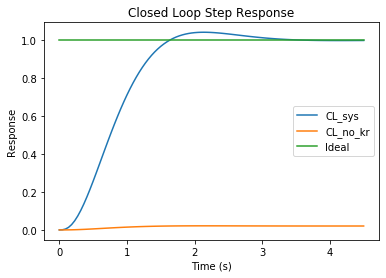

In [6]:
Acl = A - B@K
Bcl = B*kr
Ccl = Cr
Dcl = np.zeros((1,1))

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()


Here you can see how $k_r$ makes the system arrive at the ideal (given perfect information).  Without $k_r$, the system 

# Examples: Design Study A. Single Link Robot Arm
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework A.10.
> (a) Select the closed loop poles as the roots of the equation $s^2 + 2 \zeta \omega_n + \omega_n^2 = 0$
where $\zeta$ and $\omega_n$ were found in Homework A.8.

> (b) Add the state space matrices A, B, C, D derived in Homework A.6 to your param file.

> (c) Verify that the state space system is controllable by checking that rank of the controllability matrix is equal to n.

> (d) Find the feedback gain K so that the eigenvalues of (A - BK) are equal to the desired closed loop poles. Find the reference gain $k_r$ so that the DC gain from r to  is equal to one. Note that K = (kp; kd) where kp and kd are the proportional and derivative gains found in Homework A.8. Why?

> (e) Modify the control code to implement the state feedback controller. To construct the state x = ($\theta$ ; $\dot{\theta}$ )$^T$ use a digital differentiator to estimate $\dot{\theta}$.

## A - (a) Closed Loop Poles

In [8]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw10/')  # add homework directory
import armParam as P
import hw10.armParamHW10 as PP

# Desired poles: 
des_char_poly = np.array([1., 2.*PP.zeta*PP.wn, PP.wn**2.])
dpoles = np.roots(des_char_poly)
print("Desired pole locations: ", dpoles)

kp:  0.45374999999999993
ki:  0.1
kd:  0.06665499999999998
Desired pole locations:  [-3.8885+3.8896745j -3.8885-3.8896745j]


## A - (b) State Space Model 

In [0]:
# System Model
# State Space Equations
# xdot = A*x + B*u
# y = C*x
A = np.array([[0.0, 1.0],
               [0.0, -1.0*P.b/P.m/(P.ell**2)]])

B = np.array([[0.0],
               [3.0/P.m/(P.ell**2)]])

C = np.array([[1.0, 0.0]])

## A - (c) Controlability

In [12]:
Cntl = ctrb(A,B)
r = np.linalg.matrix_rank(Cntl)
print('Rank of Controllability Matrix: ', r)

Rank of Controllability Matrix:  2


## A - (d) Select Gains $K$ and $k_r$

In [13]:
K = acker(A, B, dpoles)

kr = -1.0/(C*np.linalg.inv(A-B@K)@B)

print("Feedback gain K: ", K)
print("Reference gain k_r: ", kr)

Feedback gain K:  [[0.45375    0.09998833]]
Reference gain k_r:  [[0.45375]]


## A - (e) Implement Control and Simulate
First, we are going to put the system through a quick closed loop check. 

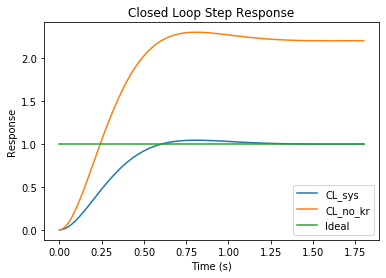

In [14]:
Acl = A - B@K
Bcl = B*kr
Ccl = C
Dcl = np.zeros((1,1))

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

### Run Simulation

In [16]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw11/')  # add homework directory
import armParam as P
from hw3.armDynamics import armDynamics
from armController import armController
from hw2.signalGenerator import signalGenerator
from hw2.armAnimation import armAnimation
from hw2.dataPlotter import dataPlotter as armPlotData

kp:  0.45374999999999993
ki:  0.1
kd:  0.06665499999999998


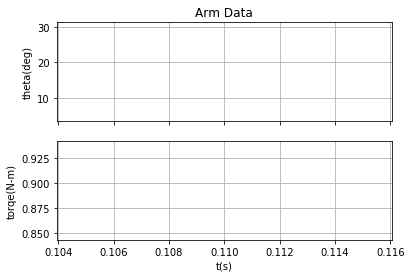

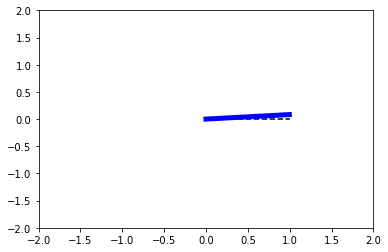

In [17]:
# instantiate arm, controller, and reference classes
arm = armDynamics()
ctrl = armController()
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
armDataPlot = armPlotData()
animation = armAnimation()

# set disturbance input
disturbance = 0.01

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, arm.state)  # Calculate the control value
        sys_input = u + disturbance
        arm.update(sys_input)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(arm.state)
    armDataPlot.update(t, ref_input, arm.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlot(dataPlot_arm):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=2, ncols=1)
  fig.tight_layout()
  plt.subplot(211)  
  plt.plot(dataPlot_arm.time_history, np.transpose([dataPlot_arm.theta_history, dataPlot_arm.theta_ref_history]))
  plt.title('Arm Data' )
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(212)
  plt.plot(dataPlot_arm.time_history, dataPlot_arm.torque_history)
  plt.ylabel('Torque (N-m)')
  plt.xlabel('time (s)')

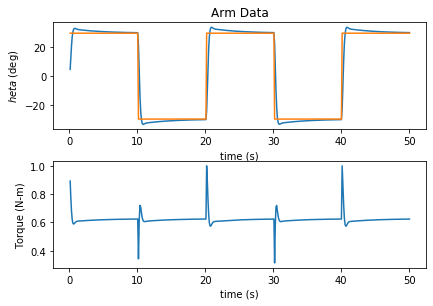

In [19]:
postProcessPlot(armDataPlot)

# Examples - Design Study B: Inverted Pendulum
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework A.10.
> (a) Select the closed loop poles as the roots of the equation $s^2 + 2 \zeta \omega_n + \omega_n^2 = 0$
where $\zeta$ and $\omega_n$ were found in Homework B.8.

> (b) Add the state space matrices A, B, C, D derived in Homework B.6 to your param file.

> (c) Verify that the state space system is controllable by checking that rank of the controllability matrix is equal to n.

> (d) Find the feedback gain K so that the eigenvalues of (A - BK) are equal to the desired closed loop poles. Find the reference gain $k_r$ so that the DC gain from r to  is equal to one. Note that K = (kp; kd) where kp and kd are the proportional and derivative gains found in Homework A.8. Why?

> (e) Modify the control code to implement the state feedback controller. To construct the state x = ($\theta$ ; $\dot{\theta}$ )$^T$ use a digital differentiator to estimate $\dot{\theta}$.

In [0]:
# Design Problem B : Pendulum
sys.path.remove('control_book_public_solutions/_a_arm/python/')
sys.path.remove('control_book_public_solutions/_a_arm/python/hw11/')

In [23]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_B_pendulum/python')
sys.path.append('control_book_public_solutions/_B_pendulum/python/hw11/')  # add homework directory
import pendulumParam as P
import hw11.pendulumParamHW11 as PP

DC_gain 1.8754253767622748
kp_th:  -26.24319727891157
kd_th:  -3.1478333333333333
kp_z:  -0.06189092517559949
ki_z:  -0.005
kd_z:  -0.1506408552390715


## B - (a)-(d) Design and build the controller


In [25]:
# gain calculation
wn_th = 2.2/PP.tr_theta  # natural frequency for angle
wn_z = 2.2/PP.tr_z  # natural frequency for position
des_char_poly = np.convolve([1, 2*PP.zeta_z*wn_z, wn_z**2],
                            [1, 2*PP.zeta_th*wn_th, wn_th**2])
des_poles = np.roots(des_char_poly)

A = np.array([[0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0],
               [0.0, -3*P.m1*P.g/4/(.25*P.m1+P.m2),
                -P.b/(.25*P.m1+P.m2), 0.0],
               [0.0, 3*(P.m1+P.m2)*P.g/2/(.25*P.m1+P.m2)/P.ell,
                3*P.b/2/(.25*P.m1+P.m2)/P.ell, 0.0]])
B = np.array([[0.0],
               [0.0],
               [1/(.25*P.m1+P.m2)],
               [-3.0/2/(.25*P.m1+P.m2)/P.ell]])

C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(cnt.ctrb(A, B)) != 4:
    print("The system is not controllable")
else:
    K = cnt.acker(A, B, des_poles)
    Cr = np.array([[1.0, 0.0, 0.0, 0.0]])
    kr = -1.0/(Cr*np.linalg.inv(A-B@K)@B)

print('K: ', K)
print('kr: ', kr)


AttributeError: ignored

## B - (b) System Model

DC_gain 1.8754253767622748
kp_th:  -26.24319727891157
kd_th:  -3.1478333333333333
kp_z:  -0.06189092517559949
ki_z:  0.0001
kd_z:  -0.1506408552390715


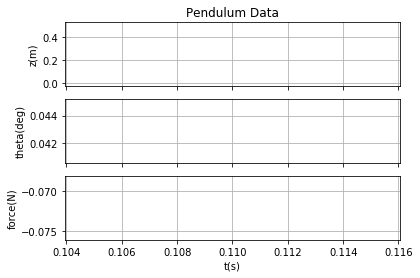

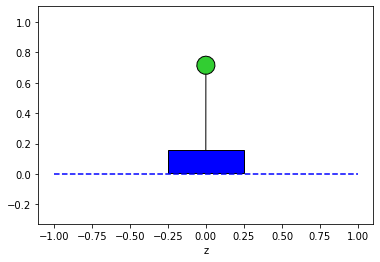

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_B_pendulum/python')
sys.path.append('control_book_public_solutions/_B_pendulum/python/hw11/')  # add homework directory
import pendulumParam as P
from hw_b.pendulumDynamics import pendulumDynamics
from hw10.pendulumController import pendulumController
from hw_a.signalGenerator import signalGenerator
from hw_a.pendulumAnimation import pendulumAnimation
from hw_a.dataPlotter import dataPlotter as pendulumPlotData


pendulum = pendulumDynamics()
ctrl = pendulumController() # put in the gains we computed above for the inner loop. 
reference = signalGenerator(amplitude=0.5, frequency=0.02)

# instantiate the simulation plots and animation
pendDataPlot = pendulumPlotData()
animation = pendulumAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, pendulum.state)  # Calculate the control value        
        pendulum.update(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(pendulum.state)
    pendDataPlot.update(t, ref_input, pendulum.state, u)
    #dataPlot.update(t, [0.0,0.0], pendulum.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotPendulum(dataPlot_pen):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_pen.time_history, np.transpose([dataPlot_pen.z_history, dataPlot_pen.zref_history]))
  plt.title('Pendulum Data' )
  plt.ylabel('$z$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_pen.time_history, np.transpose(dataPlot_pen.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_pen.time_history, dataPlot_pen.Force_history)
  plt.ylabel('Force (N)')
  plt.xlabel('time (s)')

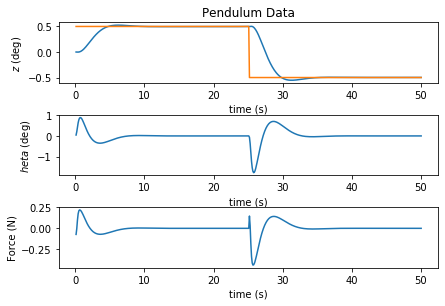

In [0]:
postProcessPlotPendulum(pendDataPlot)

# Examples - Design Study C: Satellite Control
> (a)  Modify the system dynamics file so that the parameters $J_s$, $J_p$, $k$ and $b$ vary by up to 20\% of their nominal value each time they are run (uncertainty parameter = 0.2).

>(b)  Rearrange the block diagram so that the controller is implemented as an m-function implemented at the sample rate of $T_s=0.01$.  Assume that the controller only has knowledge of the angles $\phi$ and $\theta$ as well as the reference angle $\phi_r$.

>(c)  Implement the nested PID loops designed in Problems C.8 using an m-function called satellite\_ctrl.m.   Use the dirty derivative gain of $\tau=0.05$. Tune the integrator to remove the steady state error caused by the uncertain parameters.

## C - (a) Vary Dynamic Parameters
Here is code demonstrating varying the dynamic parameters: 
```
# The parameters for any physical system are never known exactly.  Feedback
# systems need to be designed to be robust to this uncertainty.  In the simulation
# we model uncertainty by changing the physical parameters by a uniform random variable
# that represents alpha*100 % of the parameter, i.e., alpha = 0.2, means that the parameter
# may change by up to 20%.  A different parameter value is chosen every time the simulation
# is run.
alpha = 0.2  # Uncertainty parameter
self.Js = P.Js * (1+2*alpha*np.random.rand()-alpha)  # inertia of base
self.Jp = P.Jp * (1+2*alpha*np.random.rand()-alpha)  # inertia of panel
self.k = P.k * (1+2*alpha*np.random.rand()-alpha)    # spring coefficient
self.b = P.b * (1+2*alpha*np.random.rand()-alpha)    # Damping coefficient, Ns

```

## C - (b) Sample Control at $T_s$
See part A - (b) above

## C - (c) Simulate PID
Here is the simulation of our PID controller, see the ability of the control to take out state state error. 

In [0]:
# Design Problem B : Pendulum
sys.path.remove('control_book_public_solutions/_B_pendulum/python')
sys.path.remove('control_book_public_solutions/_B_pendulum/python/hw10/')

k_DC_phi 0.3781272785378374
kp_th:  49.23775510204083
kd_th:  22.169999999999998
kp_phi:  0.6098984704403007
kd_phi:  2.8573062567076946


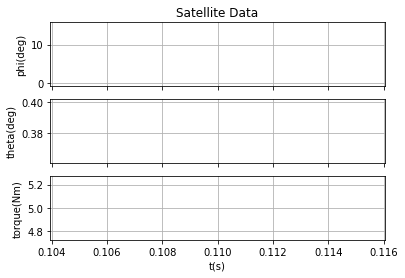

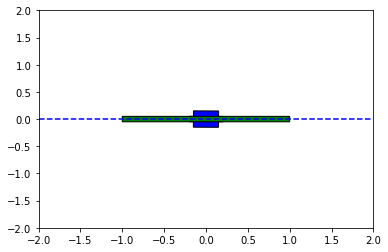

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw10')
import satelliteParam as P
from hw_b.satelliteDynamics import satelliteDynamics
from hw10.satelliteController import satelliteController
from hw_a.signalGenerator import signalGenerator
from hw_a.satelliteAnimation import satelliteAnimation
from hw_a.dataPlotter import dataPlotter as satellitePlotData
P.k = 0.1

# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics()
ctrl = satelliteController()
reference = signalGenerator(amplitude=15.0*np.pi/180.0, frequency=0.02)

# set disturbance input
disturbance = 0.50

# instantiate the simulation plots and animation
satDataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot:  # updates control and dynamics at faster simulation rate
        tau = ctrl.update(ref_input, satellite.state)  # Calculate the control value
        sys_input = tau+disturbance  # input to plant is control input + disturbance (formatted as a list)
        satellite.update(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(satellite.state)
    satDataPlot.update(t, ref_input, satellite.state, tau)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotSatellite(dataPlot_sat):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_sat.time_history, np.transpose([dataPlot_sat.phi_history, dataPlot_sat.phi_ref_history]))
  plt.title('Satellite Data' )
  plt.ylabel('$\phi$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_sat.time_history, np.transpose(dataPlot_sat.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_sat.time_history, dataPlot_sat.torque_history)
  plt.ylabel('Torque (Nm)')
  plt.xlabel('time (s)')

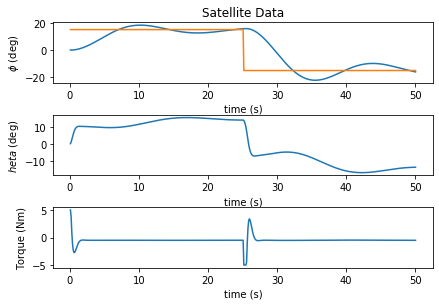

In [0]:
postProcessPlotSatellite(satDataPlot)